**Mini-Projeto(Reconhecimento de Dígitos)**

Grupo: João Paulo do Nascimento Borges e Jose Messias Marinho Olimpio

O reconhecimento de dígitos escritos a mão é um problema clássico de classificação na área de visão computacional. O problema consiste em receber uma imagem de um número escrito a mão, codificada em tons de cinza, e classificar o dígito decimal (0-9) ali contido. Para estudantes e pesquisadores das técnicas de aprendizado de máquina, o dataset MNIST, cujos exemplos de instâncias estão ilustrados na Figura 1, é utilizado para comparação de técnicas, competições e construções de novas soluções.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [4]:
test_file_path = './datasets/test.csv'
train_file_path = './datasets/train.csv'
test_df = pd.read_csv(test_file_path)
train_df = pd.read_csv(train_file_path)

np_train_df = train_df.to_numpy()[:, 1:]
np_test_df = test_df.to_numpy()[:, 1:]

DIGIT = 0
FIRST_PIXEL = 1

### Modelos de Aprendizagem

**PERCEPTRON**

In [5]:
class Perceptron:
  def __init__(self, max_iter):
    self.max_iter = max_iter

  def fit(self, _X, _y):
    dimension = len(_X[0])
    self.w = 2 * np.random.random(size=dimension) - 1
    self.best_error = dimension
    best_w = self.w
    
    for i in range(self.max_iter):

      for x_n, y_n in zip(_X, _y):
        y_pred = np.sign(np.dot(x_n, self.w))

        if y_pred != y_n:
          self.w = self.w + x_n * y_n
          error = self.__error_in(zip(_X, _y))
          if self.best_error > error:
            self.best_error = error
            best = self.w
      
      self.w = best_w

  def predict(self, x_test):
    y_pred = np.sign(np.dot(x_test, self.w))
    return np.where(y_pred == 1.0, 1, -1)

  def get_weights(self):
    return self.w[1:]

  def get_bias(self):
    return self.w[0]

  # Private

  def __error_in(self, points):
    error = 0

    for x_n, y_n in points:
      y_pred = np.sign(np.dot(x_n, self.w))
      error += 1 if y_pred != y_n else 0

    return error

**LINEAR REGRESSION**

In [6]:
class LinearRegression:
    def fit(self, _X, _y):
        X =  np.array(_X)
        y =  np.array(_y)
        xTx = np.dot(X.transpose(), X)
        inverse = np.linalg.inv(xTx)
        self.w = np.dot(np.dot( inverse, X.transpose()), y)
    
    def predict(self, X):
        return np.sign([np.dot(x_n, self.w) for x_n in X])
    
    def get_w(self):
        return self.w[1:]

    def get_bias(self):
        return self.w[0]

**LOGISTIC REGRESSION**

In [7]:
class LogisticRegression:
  def __init__(self, eta=0.1, tmax=1000, bs=32):
    self.eta = eta
    self.tmax = tmax
    self.batch_size = bs

  def fit(self, _X, _y, epsilon=0.0001):
    X = np.array(_X)
    y = np.array(_y)

    N = X.shape[0]
    d = X.shape[1]
    w = np.zeros(d)

    self.w = []

    for t in range(self.tmax):
      values_sum = 0.0

      for n in range(N):
        yN_wT = y[n] * np.transpose(w)
        values_sum += y[n] * X[n] / ( 1 + np.exp(np.dot(yN_wT, X[n])) )

      gT = -(values_sum / N)

      if(np.linalg.norm(gT) < epsilon): break

      w = w - (self.eta * gT)

    self.w = w    
    
  def predict_prob(self, X):
    return [ self.__sigmoid(x) for x in X]

  def predict(self, X):
    return [ 1 if self.__sigmoid(x) >= 0.5 else -1 for x in X]

  def get_w(self):
    return self.w[1:]

  def get_bias(self):
    return self.w[0]

  # Private Methods

  def __sigmoid(self, x):
    return (1 / (1 + np.exp(-(self.__hypothesis_function(x)))))

  def __hypothesis_function(self, x):
    return self.w[0] * x[0] + np.dot(np.transpose(self.w[1:]), x[1:])

### Funções utilitárias

In [8]:
def pos_pixel(size, i ,j):
  return i*size + j

def symmetry(image):
  size = 28
  sv = 0
  sh = 0
  
  for i in range(size):
    for j in range(int(size/2)):
      p1 = image[pos_pixel(size, i, j)]
      p2 = image[pos_pixel(size, i, (size-1)-j)]
      sv += abs(p1 - p2)
            
      p1 = image[pos_pixel(size, j, i)]
      p2 = image[pos_pixel(size, (size-1)-j, i)]
      sh += abs(p1 - p2)

  sv = sv/255
  sh = sh/255

  s = sv + sh
  
  return s
  
def intensity(image):
  return (np.sum(image)/255.0)


def get_numbers_1_and_5(df):
  filtered_data = []

  for item in df:
    if(item[0] == 1 or item[0] == 5):
      filtered_data.append(item.tolist())

  return filtered_data

def add_1_column(X):
  ones_list = map(lambda i: [1, i[0], i[1]], X)
  return np.array(list(ones_list))
  

In [9]:
def plot_linear_classifier(x, y, w, b):
  x1_min, x1_max = x[:,0].min(), x[:,0].max()
  x2_min, x2_max = x[:,1].min(), x[:,1].max()

  x1, x2 = np.meshgrid(np.linspace(x1_min-1, x1_max+1,100), np.linspace(x2_min-1, x2_max+1, 100))
  x_mesh = np.array([x1.ravel(), x2.ravel()]).T

  plt.scatter(x[:,0], x[:,1], c=y.ravel(), cmap='bwr')

  y_mesh = np.dot(x_mesh, np.array(w).reshape(1, -1).T) + b
  y_mesh = np.where(y_mesh <= 0, 0, 1)

  plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap='bwr', alpha=0.5)
  plt.xlim(x1_min-1, x1_max+1)
  plt.ylim(x2_min-1, x2_max+1)

### Classificação dos números 1 e 5

Dados de treinamento

In [10]:
new_train_df = []
images = get_numbers_1_and_5(np_train_df)

for image in images:
  symmetry_ = symmetry(image[FIRST_PIXEL:])
  intensity_ = intensity(image[FIRST_PIXEL:])

  label = -1 if image[DIGIT] == 1 else 1

  new_train_df.append([label, intensity_, symmetry_])

new_train_df = np.array(new_train_df)

Dados de teste

In [11]:
new_test_df = []
images = get_numbers_1_and_5(np_test_df)

for image in images:
  symmetry_ = symmetry(image[FIRST_PIXEL:])
  intensity_ = intensity(image[FIRST_PIXEL:])

  label = -1 if image[DIGIT] == 1 else 1

  new_test_df.append([label, intensity_, symmetry_,])

new_test_df = np.array(new_test_df)

In [12]:
# PERCEPTRON

pla = Perceptron(1)
pla.fit(add_1_column(new_train_df[:, 1:]), new_train_df[:, 0])

In [13]:
# LINEAR REGRESSION

lr = LinearRegression()
lr.fit(add_1_column(new_train_df[:, 1:]), new_train_df[:, 0])

In [24]:
# LOGISTIC REGRESSION

log_r = LogisticRegression()
log_r.fit(add_1_column(new_train_df[:, 1:]), new_train_df[:, 0])

/tmp/ipykernel_55373/596069836.py:22: RuntimeWarning: overflow encountered in exp
  values_sum += y[n] * X[n] / ( 1 + np.exp(np.dot(yN_wT, X[n])) )


### Gráficos

**PERCEPTRON**

In [35]:
# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings("ignore")

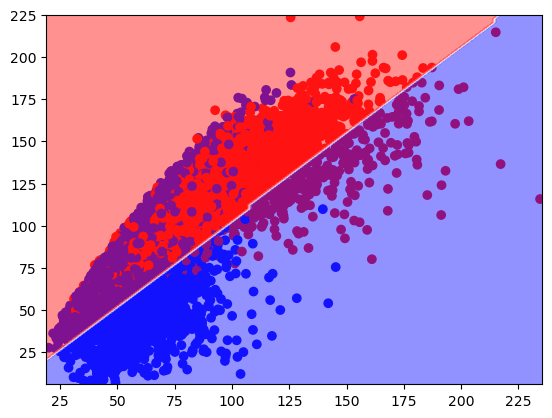

In [15]:
plot_linear_classifier(new_train_df[:, 1:], new_train_df[:, 0], pla.get_weights(), pla.get_bias())

**Matriz  de confusão**

In [16]:
confusion_matrix(new_test_df[:, 0], pla.predict(add_1_column(new_test_df[:, 1:])))

array([[ 503, 1025],
       [ 170, 1154]])

In [17]:
print(classification_report(new_test_df[:, 0], pla.predict(add_1_column(new_test_df[:, 1:]))))

              precision    recall  f1-score   support

        -1.0       0.75      0.33      0.46      1528
         1.0       0.53      0.87      0.66      1324

    accuracy                           0.58      2852
   macro avg       0.64      0.60      0.56      2852
weighted avg       0.65      0.58      0.55      2852



**REGRESSÃO LINEAR**

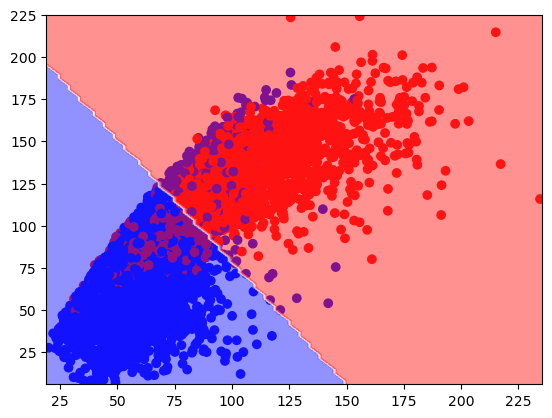

In [19]:
x_train, y_train = new_train_df[:, 1:], new_train_df[:, 0]

plot_linear_classifier(x_train, y_train, lr.get_w(), lr.get_bias())

**Matriz de confusão**

In [16]:
print(confusion_matrix(new_test_df[:, 0], lr.predict(add_1_column(new_test_df[:, 1:]))))

[[1369  159]
 [ 319 1005]]


In [20]:
print(classification_report(new_test_df[:, 0], lr.predict(add_1_column(new_test_df[:, 1:]))))

              precision    recall  f1-score   support

        -1.0       0.80      0.89      0.84      1528
         1.0       0.86      0.75      0.80      1324

    accuracy                           0.83      2852
   macro avg       0.83      0.82      0.82      2852
weighted avg       0.83      0.83      0.82      2852



**REGRESSÃO LOGÍSTICA**

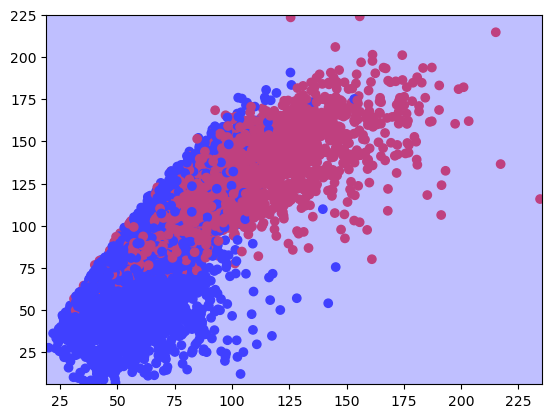

In [21]:
x_train, y_train = new_train_df[:, 1:], new_train_df[:, 0]

plot_linear_classifier(x_train, y_train, log_r.get_w(), log_r.get_bias())

**Matriz  de confusão**

In [23]:
print(confusion_matrix(new_test_df[:, 0], log_r.predict(add_1_column(new_test_df[:, 1:]))))

[[1528    0]
 [1324    0]]


In [22]:
print(classification_report(new_test_df[:, 0], log_r.predict(add_1_column(new_test_df[:, 1:]))))

              precision    recall  f1-score   support

        -1.0       0.54      1.00      0.70      1528
         1.0       0.00      0.00      0.00      1324

    accuracy                           0.54      2852
   macro avg       0.27      0.50      0.35      2852
weighted avg       0.29      0.54      0.37      2852



/home/messias/miniconda3/envs/ufpb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/messias/miniconda3/envs/ufpb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/messias/miniconda3/envs/ufpb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Classificação de todos os dígitos

Dados de treinamento

In [62]:
new_train_df = []

for image in np_train_df:
  symmetry_ = symmetry(image[FIRST_PIXEL:])
  intensity_ = intensity(image[FIRST_PIXEL:])

  new_train_df.append([image[DIGIT], symmetry_, intensity_])

new_train_df = np.array(new_train_df)

Dados de teste

In [63]:
new_test_df = []

for image in np_test_df:
  symmetry_ = symmetry(image[FIRST_PIXEL:])
  intensity_ = intensity(image[FIRST_PIXEL:])

  new_test_df.append([image[DIGIT], symmetry_, intensity_])

new_test_df = np.array(new_test_df)